## Momentum 

Momentum-based Trading is based on the assumption that Stocks which have performed will in the past, will perform better in the coming future.
 
To define 'past', we take a variable **N**, and say that : 

<centre> Momentum(For A particular stock) = Close Price(Today) - Close Price(N-day ago) </centre>

This gives us our first hyper-parameter (parameters of the model which could be changed in order to improve the model) : **N**

We would also be reshuffling our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp) at certain intervals of time, which gives us our second hyper-parameter: **T** (The time after which we'll be reshuffling our Portfolio)

Its never suggested to keep all your money invested, you must have some risk-free assets as well, so that even if you lose some of your cash in trading, you could still place better bets and regain that lost cash, Thus, We get our third Hyper-parameter: **R**, The Ratio of Total Balance, which we will using for investing.

You will not be investing in all the 30 Tickers now, Will you? You will choose the top few stocks, which show the highest promise in terms of Momentum, which brings us to another hyper-parameter: **M**, The Number of Top few stocks (based on Momentum), which you'll keep in your Portfolio.

Finally, There's some brokerage fee which you need to pay in order to place orders on the stock market, typically its less than 0.05% of the total amount : **F**


In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#Declaring the Hyperparameters

N = 50
T = 7
R = 0.8
M = 5
F = 0.0005   # 0.5% Brokerage fee

The Second step would be to define a function which reads the Prices of various Stocks into memory.

In the file DATA.csv , which we had uploaded in our repository, we have prices of 30 firms enlisted in S & P 500 Index (Apple, IBM, Cisco, Walmart and the like!) from 2nd January 2009 to 17th August 2020.

For our purposes, We'll only be requiring certain columns. On an honest note, Just getting the Columns on Ticker, Date and Adjusted Closing Price would do the job, but if you want, you may take Opening Price as well.

Read up about the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function from here, and figure out how you'll use it to do the job (You don't need all the columns!) 

In [2]:
def GetData(NameOfFile):
  # Import pandas library
  import pandas as pd
  
  # Read the csv file into a pandas DataFrame
  df = pd.read_csv(NameOfFile)
  
  # Select the columns you need
  df = df[['datadate', 'tic', 'adjcp', 'open']]
  
  # Return the DataFrame
  return df

To aid Data-Manipulation, it would be beneficial, if we split the DataFrame into many small parts each corresponding to the data corresponding to the 30 Tickers on a particular date. These small parts could then be stored in a list.

We would also be needing to remember which date is at what index, so that we can use that later. 

In [17]:
# # Define a function to split the data by date and ticker
# def PartitionData(Data):
#     DateToIndex = {}
#     # create an empty list to store the partitions
#     partitions = []
#     # loop through the rows of the data
#     for i, row in Data.iterrows():
#         # get the ticker and date from the row
#         ticker = row["tic"]
#         date = row["datadate"]
#         # create a tuple of ticker and date as the key
#         key = (ticker, date)
#         # check if the key is already in the dictionary
#         if key in DateToIndex:
#             # get the index of the corresponding partition
#             index = DateToIndex[key]
#             # append the row to that partition
#             partitions[index] = partitions[index].append(row)
#         else:
#             # create a new partition with the row
#             partition = pd.DataFrame(row).T
#             # append it to the list of partitions
#             partitions.append(partition)
#             # store the index of the partition in the dictionary
#             DateToIndex[key] = len(partitions) - 1
#     # return the list of partitions and the dictionary
#     return partitions, DateToIndex

def PartitionData(Data):
  
  DateToIndex = {}

  # Create an empty list to store the small parts
  parts = []

  # Group the DataFrame by date
  groups = Data.groupby("datadate")

  # Loop over the groups
  for i, (date, group) in enumerate(groups):
    # Append the group to the list
    parts.append(group)
    # Update the dictionary with the date and the index
    DateToIndex[date] = i

  return parts, DateToIndex    # List containing of the Data Partitioned according to Date, and the Dictionary mapping Dates to their index in the list 



Now, We need a function to calculate the Momentum value for all of our 30 Tickers.
To do this, We need to have a few things in mind:


1.   We need to start at Nth day in our list, as only then we'll be able to calculate the Momentum (This will be taken care of by later parts of the Program, when we actually run the Model)

2.   The Stock Market isn't open on all days, so we often won't be able to go N days behind, and will have to take the closest value instead(We can't just go N entries behind in the List we created and expect that to work, Why?) In order to work with dates, you should get to know more about the datetime library of Python from [here](https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/) (Especially the datetime.strftime() function) and about the [datetime.timedelta()](https://www.studytonight.com/python-howtos/how-to-add-days-to-date-in-python) function.

Also, as you may have figured it out yourself, while DataFrames are great for Data Handling and small statistical calculations, They aren't so for big calculations as the Numpy Library has both a richer variety of functions for such manipulations and is also more efficient!

After we calculate the Momentum for all our Tickers, it would be a great thing to do, if we could divide their prices by their mean(in the N day interval, as we need to see which stock outperforms others and in order to do this, it won't be fair if we take the absolute growth in numbers!(Why?)



In [18]:
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):
  # PartitionedDataFrameList : Pandas DataFrame, The Output of your last function
  # DateToIndex : Dictionary mapping dates to their index in the PartitionedDataFrameList
  # today :  Today's date (string) In Format: YYYYMMDD

  # Convert today to a string
  today = str(today)
  # Convert NdaysAgo to a string in the same format as datadate
  NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
  NdaysAgo = NdaysAgo.strftime("%Y%m%d")

  # Create an empty numpy array to store the momentum divided by mean
  momentum_by_mean = np.zeros(30)

  # Loop over the 30 tickers
  for i, ticker in enumerate(PartitionedDataFrameList[0]['tic'].unique()):
    # Find the index of the partition that contains today's date for this ticker
    # If the key is not in the dictionary, use -1 as the default value
    today_index = DateToIndex.get((ticker, today), -1)
    print(ticker)
    print(today)
    try:
      today_index = DateToIndex[(ticker, today)]
    except:
      today_index = -1
    print(today_index)
    # Check if the index is valid
    if today_index != -1:
      print('not else')
      # Find the index of the partition that contains NdaysAgo's date for this ticker
      # If NdaysAgo is not in the data, use the closest date before it
      NdaysAgo_index = DateToIndex.get((ticker, NdaysAgo), today_index - N)
      # Get today's adjusted close price for this ticker from the partition
      today_price = PartitionedDataFrameList[today_index].loc[PartitionedDataFrameList[today_index]['tic'] == ticker, 'adjcp'].item()
      # Get NdaysAgo's adjusted close price for this ticker from the partition
      NdaysAgo_price = PartitionedDataFrameList[NdaysAgo_index].loc[PartitionedDataFrameList[NdaysAgo_index]['tic'] == ticker, 'adjcp'].item()
      # Calculate the momentum as the difference between today's price and NdaysAgo's price
      momentum = today_price - NdaysAgo_price
      # Calculate the mean of the adjusted close prices in the N-day period for this ticker
      mean = PartitionedDataFrameList[today_index]['adjcp'].mean()
      # Divide the momentum by the mean and store it in the numpy array
      momentum_by_mean[i] = momentum / mean
    else:
      # Set the momentum by mean to zero for this ticker
      momentum_by_mean[i] = 0
  
  # Return the numpy array
  return momentum_by_mean

# GetMomentumBasedPriority(PartitionedData, DateToIndex, today)
# print(PartitionedData)

# def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):
#     today = str(today)
#     NdaysAgo = datetime.date(int(today[0:4]),int(today[4:6]),int(today[6:])) + datetime.timedelta(days = -N)
#     NdaysAgo = NdaysAgo.strftime("%Y%m%d")
    
#     momentum_by_mean = np.zeros(30)
#     top_stocks = []
#     for i, ticker in enumerate(PartitionedDataFrameList[0]['tic'].unique()):
#         today_index = DateToIndex.get((ticker, today), -1)
#         if today_index != -1:
#             NdaysAgo_index = DateToIndex.get((ticker, NdaysAgo), today_index - N)
#             today_price = PartitionedDataFrameList[today_index].loc[PartitionedDataFrameList[today_index]['tic'] == ticker, 'adjcp'].item()
#             NdaysAgo_price = PartitionedDataFrameList[NdaysAgo_index].loc[PartitionedDataFrameList[NdaysAgo_index]['tic'] == ticker, 'adjcp'].item()
#             momentum = today_price - NdaysAgo_price
#             mean = PartitionedDataFrameList[today_index]['adjcp'].mean()
#             momentum_by_mean[i] = momentum / mean
            
#             # Add top M stocks to the list
#             if len(top_stocks) < M:
#                 top_stocks.append(ticker)
#             else:
#                 min_idx = np.argmin(momentum_by_mean)
#                 if momentum_by_mean[i] > momentum_by_mean[min_idx]:
#                     top_stocks[min_idx] = ticker  
                    
#     # Assign weights to top stocks            
#     top_weights = np.zeros(30)
#     weight_increment = 1 / M
#     for i, ticker in enumerate(top_stocks):
#         top_weights[PartitionedDataFrameList[0]['tic'] == ticker] = weight_increment * (i+1)
            
#     return top_weights  

Even after you have got your Momentum-based priorities, and have decided which stocks to buy and what will be the weight of each, you still need to figure out how much of each will you buy. To do this, first you'll sell all your pre-owned stocks which will increase your cash in hand, then you'll know the stocks to buy and their relative weights (given by their Momentum/mean) and you need a function which tells you how many stocks to buy for each ticker!

In [19]:
def GetBalanced(prices, weights,balance):
  # prices : Numpy array containing Prices of all the 30 Stocks
  # weights : Multi-hot Numpy Array : The Elements corresponding to stocks which are to be bought(Top M Stocks with positive Momentum Indicator) are set to their priority, All other elements are set to zero.
  # Returns Numpy array containing the number of shares to buy for each stock!

  # Import numpy library
  import numpy as np

  # Normalize the weights by dividing them by their sum
  weights = weights / weights.sum()

  # Multiply the balance by the normalized weights to get the amount of money to invest in each stock
  amount = balance * weights

  # Divide the amount by the prices to get the number of shares to buy for each stock
  shares = amount / prices

  # Round down the number of shares to get integer values
  shares = np.floor(shares)

  # Return the numpy array of the number of shares
  return shares


Now, We need something to simulate our [Portfolio](https://www.investopedia.com/terms/p/portfolio.asp). In order to do that we need a class, which has certain  basic features and functionalities.

Features : 


1.   Your Initial Balance
2.   Your Current Balance
3.   A list(/any other container) storing the number of stocks of each ticker currently in possession. (Numpy Array prefered)
4.   Most recent prices of all the stocks (As a Numpy array)

Functionalities: 



1.   Calculating current Net Worth (Balance+Total Evaluation of all Stocks owned!) 
2.   Buying a Particular Stock (Keep the Transaction fee in mind!)
3.   Selling a particular Stock whole (Keep the Transaction Fee in mind!)
4.   Rebalance Portfolio  (Takes Numpy array as input)
5.   Function to change the value of most recent prices stored (Takes Numpy array as input)





In [20]:
class PortFolio:
  def __init__(self, initial_balance, num_stocks):
    # initial_balance : The amount of money you start with
    # num_stocks : The number of different stocks in the market
    # Initialize the balance attribute to the initial balance
    self.balance = initial_balance
    # Initialize the stocks attribute to a numpy array of zeros with length equal to num_stocks
    self.stocks = np.zeros(num_stocks)
    # Initialize the prices attribute to a numpy array of ones with length equal to num_stocks
    self.prices = np.ones(num_stocks)

  def SellStock(self, index):
  #index : The index of the Stock to sell (0-29)
    # Check if the index is valid and the portfolio has some shares of that stock
    if 0 <= index < len(self.stocks) and self.stocks[index] > 0:
      # Calculate the amount of money received from selling all shares of that stock
      amount = self.stocks[index] * self.prices[index]
      # Deduct the transaction fee from the amount
      amount -= F * amount
      # Update the balance attribute by adding the amount
      self.balance += amount
      # Update the stocks attribute by setting the number of shares of that stock to zero
      self.stocks[index] = 0

  def BuyStock(self, index, number):
  #index : The index of the Stock to buy (0-29) 
  #number : Number of shares to buy (float)
    # Check if the index is valid and the number of shares is positive
    if 0 <= index < len(self.stocks) and number > 0:
      # Calculate the cost of buying the number of shares of that stock
      cost = number * self.prices[index]
      # Add the transaction fee to the cost
      cost += F * cost
      # Check if the portfolio has enough balance to afford the cost
      if self.balance >= cost:
        # Update the balance attribute by subtracting the cost
        self.balance -= cost
        # Update the stocks attribute by adding the number of shares of that stock
        self.stocks[index] += number

  def CalculateNetWorth(self):
  #Return Net Worth (All Shares' costs+ Balance)
    # Calculate the total value of all shares owned by multiplying the stocks and prices arrays and summing them up
    total_value = np.sum(self.stocks * self.prices)
    # Return the net worth by adding the balance and total value
    return self.balance + total_value

  def ChangePricesTo(self, newPriceVector):
  # newPriceVector : Numpy array containing the prices of all the stocks for the current day
    # Check if the new price vector has the same length as the prices attribute
    if len(newPriceVector) == len(self.prices):
      # Update the prices attribute to the new price vector
      self.prices = newPriceVector

  def RebalancePortFolio(self, newWeights):  
  # newWeights : Numpy array containing Momentum/Mean for all stocks in the N-day period
  # First sell all your pre-owned Stock (make sure to take transaction fee into account!)
  # This would change your total balance
  # Then take the top M(/might be less than M, if >(30-M) had negative Momentum) and send them to the GetBalanced() Function
  # Then take that output and pass them to the BuyStocks function!
    # Loop over all stocks and sell them using the SellStock method
    for i in range(len(self.stocks)):
      self.SellStock(i)
    
    # Sort the new weights in descending order and get their indices
    sorted_indices = np.argsort(newWeights)[::-1]
    
    # Get the top M indices that have positive weights
    top_indices = sorted_indices[newWeights[sorted_indices] > 0][:M]
    
    # Get the prices and weights of the top M stocks using indexing
    top_prices = self.prices[top_indices]
    top_weights = newWeights[top_indices]
    
    # Get the balanced number of shares for each top stock using the GetBalanced function
    balanced_shares = GetBalanced(top_prices, top_weights, self.balance)
    
    # Loop over the top M stocks and buy them using the BuyStock method and balanced shares
    for i in range(len(top_indices)):
      self.BuyStock(top_indices[i], balanced_shares[i])


With that the difficult part is over!

Now, all you need to work on is a main loop, which calls all these functions

In [22]:
N = 50
T = 7
# Initialize the portfolio with the initial balance and the number of stocks
myPortfolio = PortFolio(1000000, 30)
# Create an empty list to store the net worth after each trade
NetWorthAfterEachTrade = []

#First Get the Data
# Read the csv file into a pandas DataFrame
Data = GetData("DATA.csv")
#print(Data)
# Partition the data by date and ticker and get the date to index mapping
PartitionedData, DateToIndex = PartitionData(Data)
# print(PartitionedData)
# print(DateToIndex)
#Start processing from the (N+1)th Day(among the ones recorded in the Data)
for i in range(N+1, len(PartitionedData)):
  # Change the Prices to the ith Term
  # Get the prices of all stocks for the current date from the partition
  newPriceVector = PartitionedData[i]['adjcp'].values
  # Update the portfolio prices using the ChangePricesTo method
  myPortfolio.ChangePricesTo(newPriceVector)
  
  # Get NetWorth and store in list
  # Calculate the net worth using the CalculateNetWorth method
  net_worth = myPortfolio.CalculateNetWorth()
  # Append the net worth to the list
  NetWorthAfterEachTrade.append(net_worth)

  # Check if you need to rebalance Portfolio's Today
  # If today is a multiple of T days after the (N+1)th day, then rebalance the portfolio
  if (i - (N+1)) % T == 0:
    # Get the date of today from the partition
    today = PartitionedData[i]['datadate'].iloc[0]
    # Get the momentum based priority for all stocks using the GetMomentumBasedPriority function
    newWeights = GetMomentumBasedPriority(PartitionedData, DateToIndex, today)
    # Rebalance the portfolio using the RebalancePortFolio method and new weights
    print(newWeights)
    myPortfolio.RebalancePortFolio(newWeights)


AAPL
20090318
-1
AXP
20090318
-1
BA
20090318
-1
CAT
20090318
-1
CSCO
20090318
-1
CVX
20090318
-1
DD
20090318
-1
DIS
20090318
-1
GS
20090318
-1
HD
20090318
-1
IBM
20090318
-1
INTC
20090318
-1
JNJ
20090318
-1
JPM
20090318
-1
KO
20090318
-1
MCD
20090318
-1
MMM
20090318
-1
MRK
20090318
-1
MSFT
20090318
-1
NKE
20090318
-1
PFE
20090318
-1
PG
20090318
-1
RTX
20090318
-1
TRV
20090318
-1
UNH
20090318
-1
V
20090318
-1
VZ
20090318
-1
WBA
20090318
-1
WMT
20090318
-1
XOM
20090318
-1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
AAPL
20090327
-1
AXP
20090327
-1
BA
20090327
-1
CAT
20090327
-1
CSCO
20090327
-1
CVX
20090327
-1
DD
20090327
-1
DIS
20090327
-1
GS
20090327
-1
HD
20090327
-1
IBM
20090327
-1
INTC
20090327
-1
JNJ
20090327
-1
JPM
20090327
-1
KO
20090327
-1
MCD
20090327
-1
MMM
20090327
-1
MRK
20090327
-1
MSFT
20090327
-1
NKE
20090327
-1
PFE
20090327
-1
PG
20090327
-1
RTX
20090327
-1
TRV
20090327
-1
UNH
20090327
-1
V
20090327
-1
VZ
20090327
-1
WBA
2

In [12]:
grouped_df = Data.groupby('datadate')

In [14]:
# Create separate DataFrames for each group
ticker_dfs = {}
for ticker, group in grouped_df:
    ticker_dfs[ticker] = group.copy()
# Access individual ticker DataFrames
for ticker, df in ticker_dfs.items():
    print(f"Date: {ticker}")
    print(df)
    print('---')

Date: 20090102
    datadate   tic      adjcp       open
0   20090102  AAPL  12.964286  12.268571
1   20090102   AXP  19.330000  18.570000
2   20090102    BA  45.250000  42.800000
3   20090102   CAT  46.910000  44.910000
4   20090102  CSCO  16.960000  16.410000
5   20090102   CVX  76.520000  74.230000
6   20090102    DD  46.234623  45.544554
7   20090102   DIS  23.920000  22.760000
8   20090102    GS  86.760000  84.020000
9   20090102    HD  24.130000  23.070000
10  20090102   IBM  87.370000  83.890000
11  20090102  INTC  15.200000  14.690000
12  20090102   JNJ  60.650000  60.130000
13  20090102   JPM  31.350000  31.190000
14  20090102    KO  22.950000  22.700000
15  20090102   MCD  63.750000  62.380000
16  20090102   MMM  59.190000  57.550000
17  20090102   MRK  31.000000  30.460000
18  20090102  MSFT  20.330000  19.533000
19  20090102   NKE  13.265000  12.737500
20  20090102   PFE  18.270000  17.880000
21  20090102    PG  62.800000  61.690000
22  20090102   RTX  54.950000  53.460000
2

##Moment of Truth

Time to check, if your Program actually works!

Plot the data you collected in various ways and see if what you did worked!

Feel free to use whichever one of Matplotlib or Seaborn you want to.

You should try changing the hyper-parameters to increase(/decrease) your performance!


[1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0

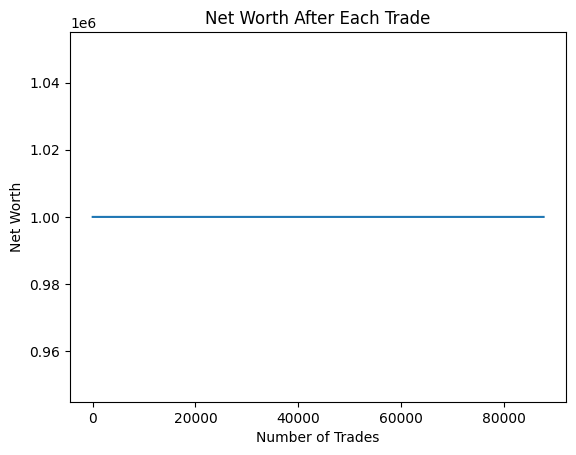

In [ ]:
def VizualizeData(NetWorthAfterEachTrade):
  # NetWorthAfterEachTrade : List containing net worth after each trade

  # Import matplotlib.pyplot and seaborn libraries
  import matplotlib.pyplot as plt

  # Create a figure and an axis object using plt.subplots()
  fig, ax = plt.subplots()

  # Plot the net worth after each trade as a line plot on the axis object
  ax.plot(NetWorthAfterEachTrade)

  # Set the title, xlabel and ylabel of the axis object
  ax.set_title("Net Worth After Each Trade")
  ax.set_xlabel("Number of Trades")
  ax.set_ylabel("Net Worth")

  # Show the figure using plt.show()
  plt.show()

print(NetWorthAfterEachTrade)
VizualizeData(NetWorthAfterEachTrade)


  

You may use this cell to write about what results you got!